# Part 3: Compression

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

2024-09-19 11:43:34.646874: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 11:43:34.649374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 11:43:34.682814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 11:43:34.682835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 11:43:34.682856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Now construct a model
We'll use the same architecture as in part 1: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [4]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2024-09-19 11:44:02.170454: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_2',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_2/KERAS_check_best_model.h5')

Epoch 1/30
  1/487 [..............................] - ETA: 15:23 - loss: 1.7080 - accuracy: 0.2139WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.0067s). Check your callbacks.


473/487 [============================>.] - ETA: 0s - loss: 0.9531 - accuracy: 0.6876
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 0.82827, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.82827, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 4ms/step - loss: 0.9495 - accuracy: 0.6889 - val_loss: 0.8283 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 2/30
 41/487 [=>............................] - ETA: 1s - loss: 0.8179 - accuracy: 0.7339

/home/jschulte/.conda/envs/hls4ml-testing/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/487 [===========================>..] - ETA: 0s - loss: 0.7972 - accuracy: 0.7405
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 0.82827 to 0.78032, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.82827 to 0.78032, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 2: saving model to model_2/KERAS_check_model_last.h5

Epoch 2: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.7964 - accuracy: 0.7407 - val_loss: 0.7803 - val_accuracy: 0.7459 - lr: 0.0010
Epoch 3/30
487/487 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.7493
***callbacks***
saving losses to model_2/losses.log

Epoch 3: val_loss improved from 0.78032 to 0.76543, saving model to model_2/KERAS_check_best_model.h5

Epoch 3: val_loss improved from 0.78032 to 0.76543, saving model to model_2/KERAS_check_best_model_weig

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.75


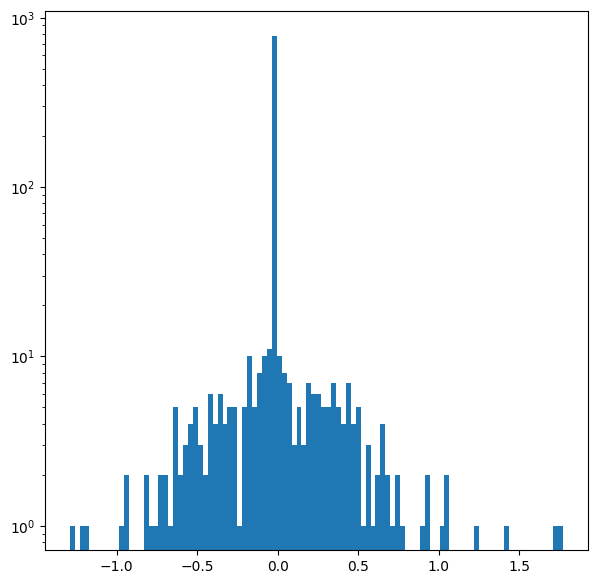

In [7]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

5188/5188 [==============================] - 4s 819us/step
Accuracy unpruned: 0.7643975903614458
Accuracy pruned:   0.7625722891566266


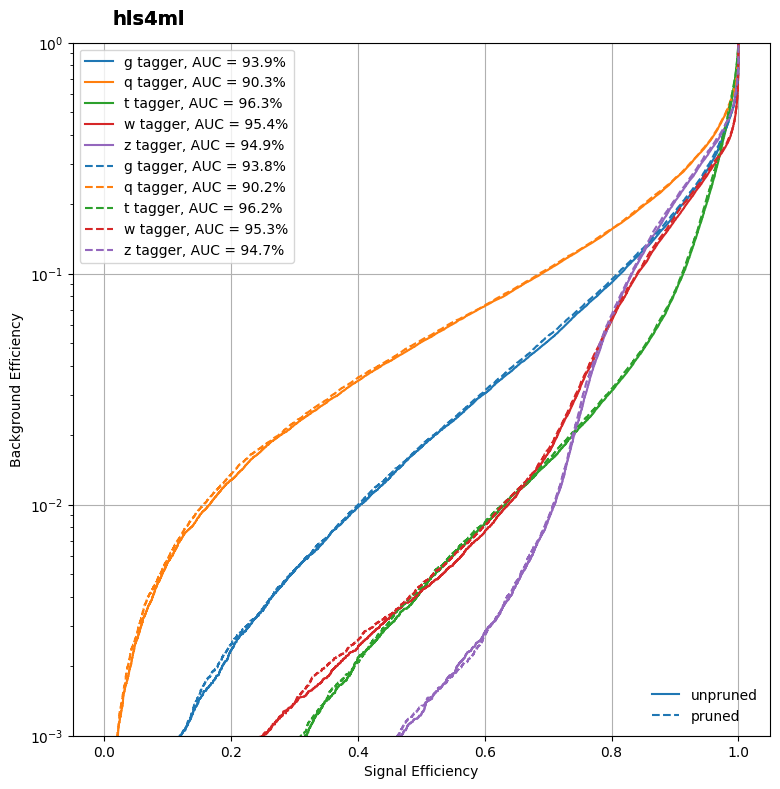

In [8]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['unpruned', 'pruned'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vitis_hls.log`

In [9]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.compile()
hls_model.build(csim=False)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}

/home/jschulte/.conda/envs/hls4ml-testing/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done

****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.1 (64-bit)
  **** SW Build 5069499 on May 21 2024
  **** IP Build 5075265 on Wed May 22 21:45:21 MDT 2024
  **** SharedData Build 5076995 on Wed May 22 18:29:18 MDT 2024
  **** Start of session at: Thu Sep 19 11:45:13 2024
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /home/tools/Xilinx/Vitis_HLS/2024.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'jschulte' on host 'COS-6PRIME-2955.science.purdue.edu' (Linux_x86_64 version 5.14.0-427.20.1.el9_4.x86_64) on Thu Sep 19 11:45:15 EDT 2024
INFO: [HLS 200-10] In directory '/home/jschulte/hls4ml-tutorial/model_2/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/home/jschulte/hls4ml-tutorial/model_2/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-1510] Run

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.172',
  'BestLatency': '12',
  'WorstLatency': '12',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '8',
  'DSP': '834',
  'FF': '5196',
  'LUT': '33849',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [10]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

Found 1 solution(s) in model_2/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Thu Sep 19 11:46:49 2024

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  4.172 ns|     0.62 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------+

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vitis HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

In [11]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Thu Sep 19 11:32:21 2024

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  4.371 ns|     0.62 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------+-